---

## Exercise 4 : SARIMA-GARCH model, B 

We use the Gamestop (GME) stock, which is a stock favored by retail investors and gained a lot of traction thanks to a massive number of reddit users artificially making the price go up, with the clear intent to perform a short squeeze in order to "punish" big hedge funds which were "unfairly" short selling the stock. 
This lack of fundamental analysis and clear non-stationarity in the returns, and heteroskedasticity, makes it interesting to try to apply a SARIMA-GARCH model to this stock.

### Imports

In [ ]:
import polars as pl
import numpy as np
import yfinance as yf
from datetime import date

import matplotlib.pyplot as plt

# from statsmodels.tsa.stattools import adfuller
# from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from useful_functions import check_stationarity, perform_lb_test
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model

### Pre-processing of the data

In [2]:
data = (
    pl.DataFrame(
        yf.download('GME', start='2010-01-01', end='2023-12-26').reset_index()
    )
    .select(
        pl.col("^.*Date.*$").cast(pl.Date).alias("date"), 
        pl.col("^.*Close.*$").alias("close")
    )
    .with_columns(
        pl.col("close").pct_change().alias('returns')
    )
    .drop_nulls()
)

[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

date,close,returns
date,f64,f64
2010-01-05,3.959006,0.027075
2010-01-06,4.04485,0.021683
2010-01-07,3.44393,-0.148564
2010-01-08,3.415314,-0.008309
2010-01-11,3.420364,0.001479


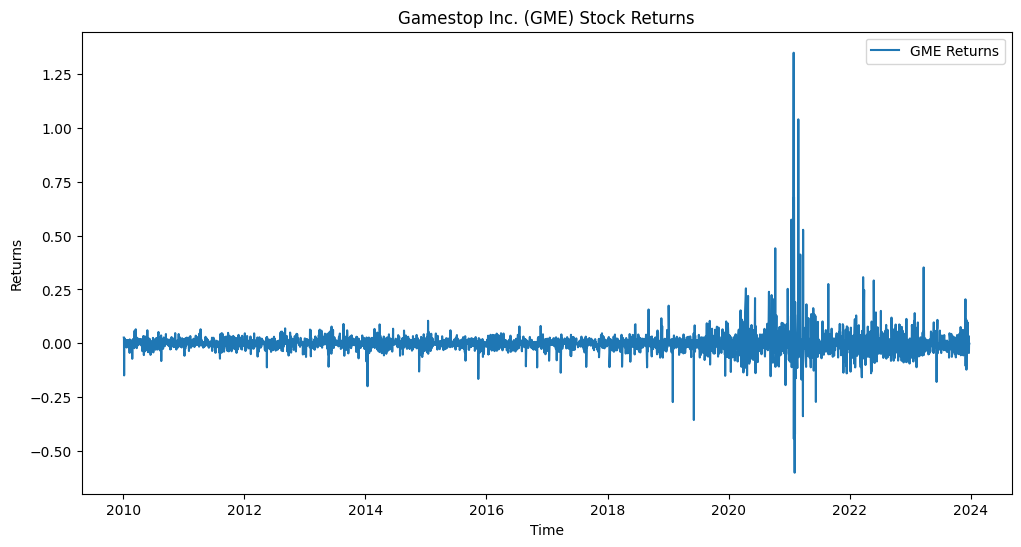

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(data.to_pandas().set_index('date')['returns'], label='GME Returns')
plt.title('Gamestop Inc. (GME) Stock Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()


### Checking for seasonality, stationarity and serial correlation

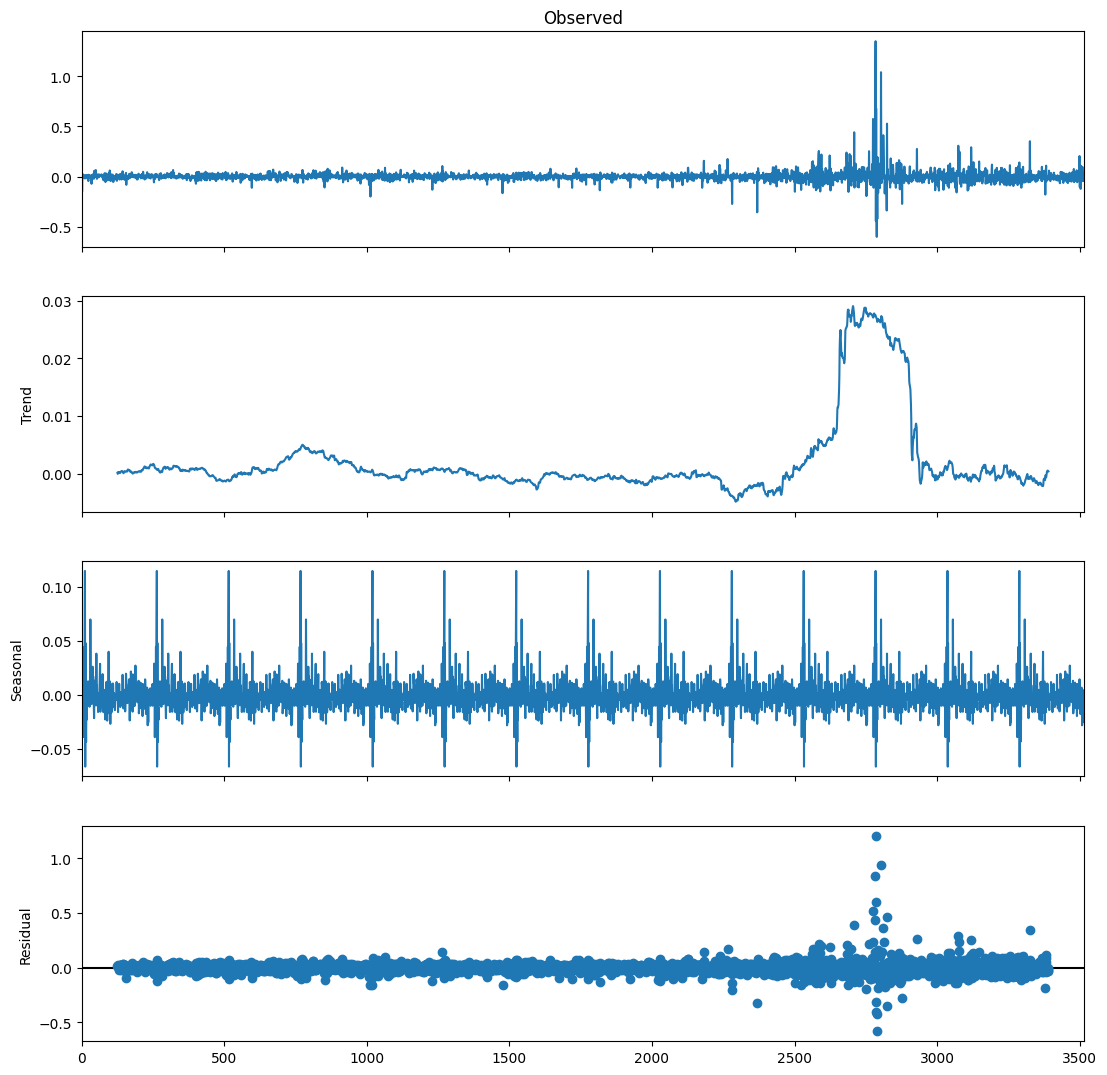

In [5]:
decomposition = seasonal_decompose(data.select('returns'), model='additive', period=252) 
fig = decomposition.plot()
fig.set_size_inches(12, 12)
plt.show()

We observe some seasonality, approximately every 252 days

In [6]:
check_stationarity(data.select('returns'))

ADF Statistic: -8.056378437827771
p-value: 1.6881992295531835e-12
Critical Values: 
 ['1% : -3.432225642776137', '5% : -2.8623687523122516', '10% : -2.5672111593871447']
We reject the null hypothesis at 5%.
 Data most probably has no unit root and is stationary


In [7]:
perform_lb_test(data.select("returns"))

LB Statistic: 495.75026755448573
p-value: 8.978195773165575e-86
We reject the null hypothesis 
 There is most probably significant serial correlation in the returns.


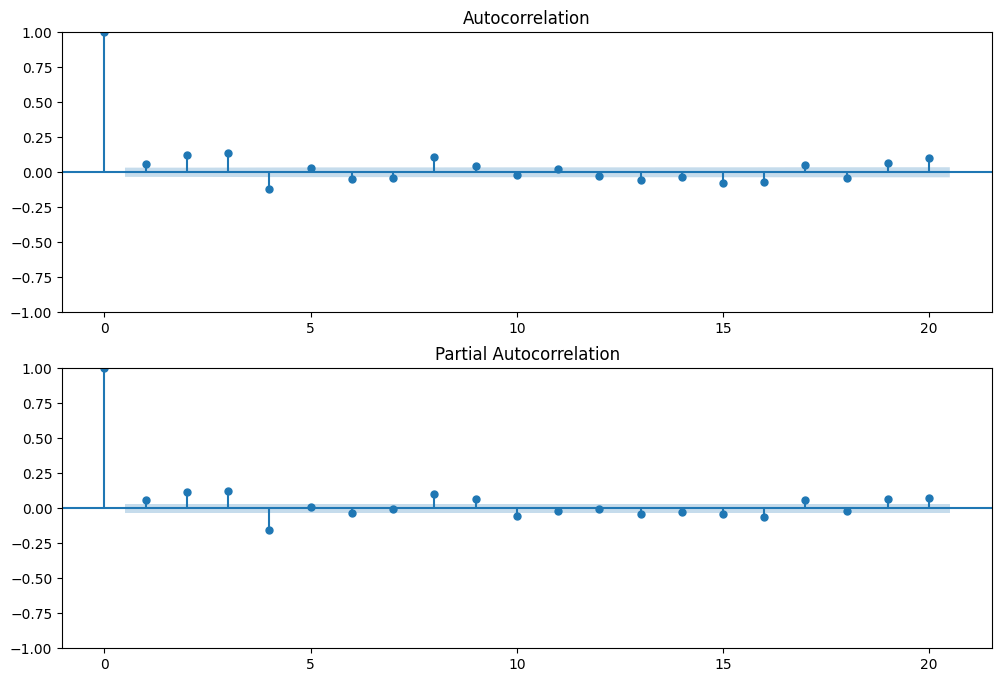

In [8]:
    
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.select("returns"), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.select("returns"), lags=20, ax=ax2, method='ywm')

We find significant autocorrelation at lags 2/3/4, with a light alternating geometrical decay

### Fitting the SARIMA model 

We define the in-sample and out of sample time series :

In [9]:
in_sample = data.filter(pl.col('date').le(date(2019,12,31)))
out_of_sample = data.filter(pl.col('date').gt(date(2019,12,31))) #strictly greater than last day of december => starts in Jan2020

We can then estimate the model on the in-sample

In [10]:
sarima_model = sm.tsa.SARIMAX(in_sample.select('returns').to_pandas(), order=(4, 0, 4), seasonal_order=(0, 0, 0, 0))
sarima_results = sarima_model.fit(disp=False)

c:\Users\faune\miniconda3\envs\timeseriescourse\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\faune\miniconda3\envs\timeseriescourse\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [11]:
print(sarima_results.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 2515
Model:               SARIMAX(4, 0, 4)   Log Likelihood                5538.610
Date:                Sat, 28 Dec 2024   AIC                         -11059.220
Time:                        13:36:10   BIC                         -11006.750
Sample:                             0   HQIC                        -11040.177
                               - 2515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0449      1.762      0.025      0.980      -3.409       3.499
ar.L2          0.1273      0.367      0.347      0.728      -0.591       0.846
ar.L3         -0.2219      0.462     -0.481      0.6

In [12]:
train_pred = sarima_results.predict(start=0, end=len(in_sample.select('returns').to_pandas())-1, typ='levels')

In [ ]:
sarima_forecast = sarima_results.get_forecast(steps=len(out_of_sample.select('returns').to_pandas()))
sarima_mean_forecast = sarima_forecast.predicted_mean
sarima_conf_int = sarima_forecast.conf_int()


In [ ]:
train = in_sample.select('returns').to_pandas()['returns']
test = out_of_sample.select('returns').to_pandas()['returns']
# train_size = len(train)

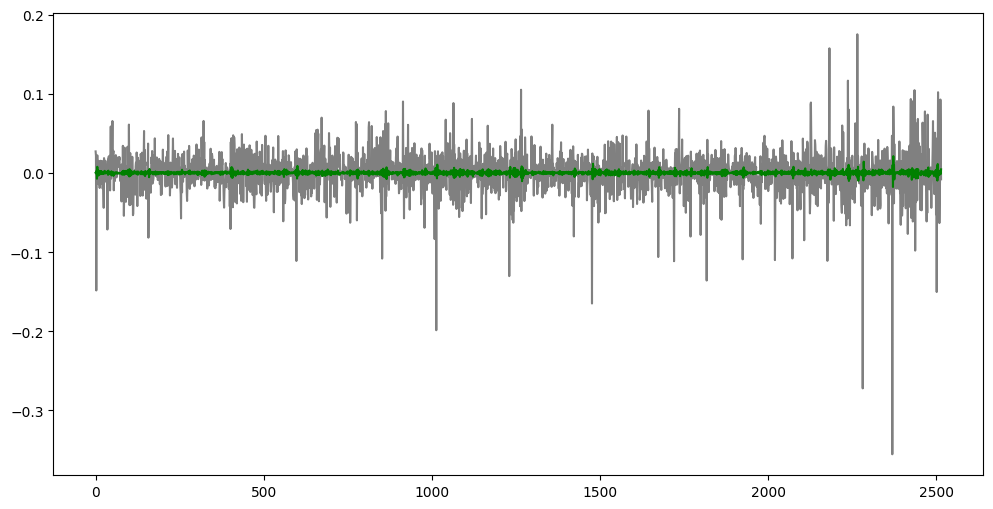

In [33]:
plt.figure(figsize=(12,6))
plt.plot(train, label='Training Data', color='gray')
plt.plot(train_pred, label='In-Sample Forecast', color='green')

In [37]:
train_size = int(len(in_sample))

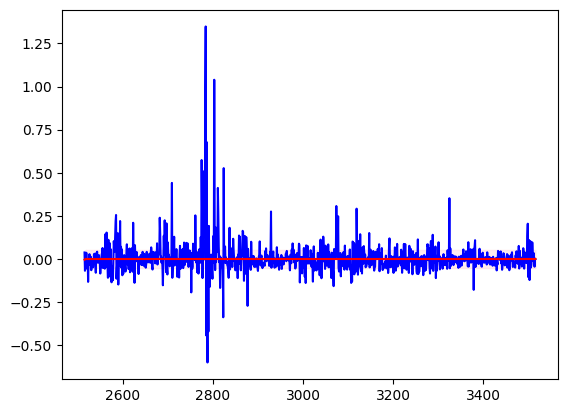

In [47]:
plt.plot(range(train_size, train_size + len(test)), test, label='Actual Test Data', color='blue')
plt.plot(range(train_size, train_size + len(test)), sarima_mean_forecast, label='Out-of-Sample Forecast', color='red')
plt.fill_between(range(train_size, train_size + len(test)), sarima_conf_int['lower returns'], sarima_conf_int['upper returns'], color='pink', alpha=0.3, label='95% Confidence Interval')

### Fitting the GARCH model

We get the residuals from the SARIMA model, perform tests and then fit the model

In [51]:
residuals = sarima_results.resid

In [52]:
check_stationarity(residuals)

ADF Statistic: -50.11748019247102
p-value: 0.0
Critical Values: 
 ['1% : -3.4329538144697187', '5% : -2.8626903542179405', '10% : -2.567382377622466']
We reject the null hypothesis at 5%.
 Data most probably has no unit root and is stationary


In [53]:
perform_lb_test(residuals, lags=20)

LB Statistic: 14.630507009951359
p-value: 0.7971453243434982
We do not reject the null hypothesis 
 There is most probably no significant serial correlation in the returns.


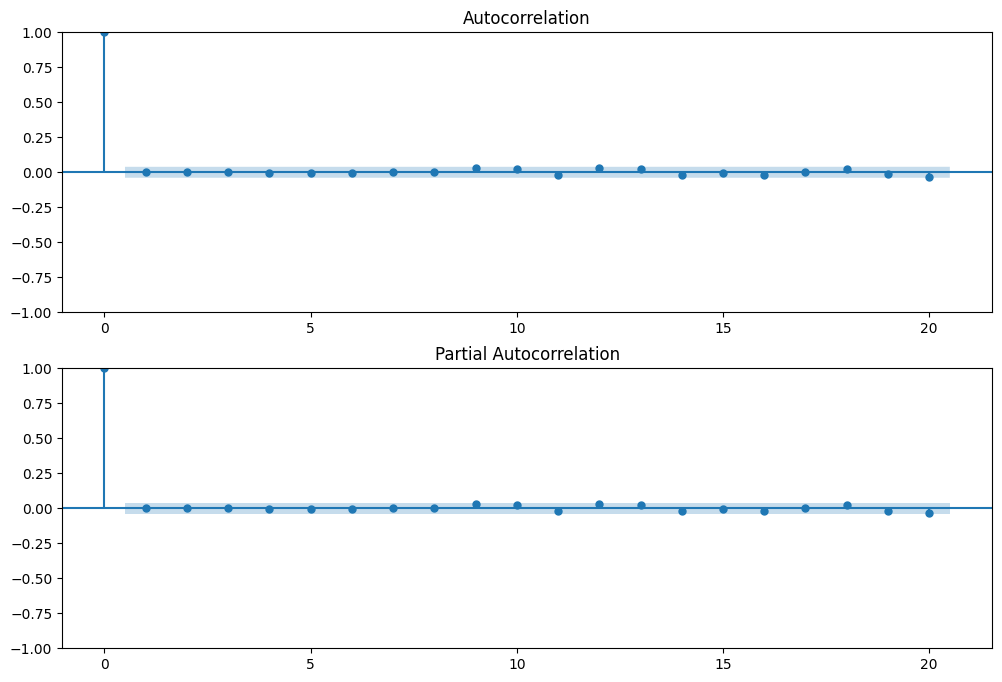

In [54]:
    
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=20, ax=ax2, method='ywm')

We find small autocorrelation at lags 11, 16 and 20

In [55]:
arch_test_result = het_arch(residuals)
print(arch_test_result)

(np.float64(4.896133116968367), np.float64(0.8980074681724161), 0.4884179475688438, 0.8985829887320613)


In [56]:
# Interpret the results
lm_test_stat, lm_p_value, f_test_stat, f_p_value = arch_test_result
if lm_p_value < 0.05:
    print("Reject the null hypothesis (Lagrange Multiplier test): There is significant ARCH effect in the returns.")
else:
    print("Fail to reject the null hypothesis (Lagrange Multiplier test): There is no significant ARCH effect in the returns.")

if f_p_value < 0.05:
    print("Reject the null hypothesis (F-test): There is significant ARCH effect in the returns.")
else:
    print("Fail to reject the null hypothesis (F-test): There is no significant ARCH effect in the returns.")


Fail to reject the null hypothesis (Lagrange Multiplier test): There is no significant ARCH effect in the returns.
Fail to reject the null hypothesis (F-test): There is no significant ARCH effect in the returns.


In [57]:

# Fit a GARCH(1,1) model to the returns
garch_model = arch_model(10*residuals, vol='Garch', p=11, q=11)
garch_results = garch_model.fit(disp='off')

# Print the summary of the model
print(garch_results.summary())

c:\Users\faune\miniconda3\envs\timeseriescourse\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07157. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -118.466
Distribution:                  Normal   AIC:                           284.931
Method:            Maximum Likelihood   BIC:                           424.852
                                        No. Observations:                 2515
Date:                Sat, Dec 28 2024   Df Residuals:                     2514
Time:                        13:50:06   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -4.0953e-04  6.543e-03 -6.259e-02      0.

### Rolling window 

We then generate the forecasts using a rolling window with both models

In [61]:
# Function to fit SARIMA-GARCH and forecast
def sarima_garch_forecast(train_data, steps=1):
    # Fit SARIMA model
    sarima_model = sm.tsa.SARIMAX(train_data, order=(4, 0, 4), seasonal_order=(0, 0, 0, 0))
    sarima_results = sarima_model.fit(disp=False)
    sarima_forecast = sarima_results.get_forecast(steps=steps)
    sarima_mean_forecast = sarima_forecast.predicted_mean

    # Get the residuals from the SARIMA model
    residuals = sarima_results.resid * 100 #we adjust the scale so that the model fits better

    # Fit GARCH model to the residuals
    garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
    garch_results = garch_model.fit(disp='off')
    garch_forecast = garch_results.forecast(horizon=steps)
    garch_variance_forecast = garch_forecast.variance.values[-1, :]

    return sarima_mean_forecast, garch_variance_forecast

# Rolling window forecast
rolling_window = 1008  # 4 years of trading days
forecasts = []
variances = []

for i in range(rolling_window, len(in_sample)):
    train_data = in_sample[i-rolling_window:i]
    sarima_mean_forecast, garch_variance_forecast = sarima_garch_forecast(train_data.to_pandas()['returns'], steps=1)
    forecasts.append(sarima_mean_forecast.values[-1])
    variances.append(garch_variance_forecast[-1])

forecasts = np.array(forecasts)
variances = np.array(variances)


c:\Users\faune\miniconda3\envs\timeseriescourse\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\faune\miniconda3\envs\timeseriescourse\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\faune\miniconda3\envs\timeseriescourse\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\faune\miniconda3\envs\timeseriescourse\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregre

KeyboardInterrupt: 

In [ ]:
out_of_sample_forecasts = []
out_of_sample_variances = []

for i in range(rolling_window, len(in_sample) + len(out_of_sample)):
    train_data = in_sample.select('returns').to_pandas()['returns'][i-rolling_window:i]
    sarima_mean_forecast, garch_variance_forecast = sarima_garch_forecast(train_data, steps=1)
    out_of_sample_forecasts.append(sarima_mean_forecast.values[-1])
    out_of_sample_variances.append(garch_variance_forecast[-1])

# out_of_sample_forecasts = np.array(out_of_sample_forecasts)
# out_of_sample_variances = np.array(out_of_sample_variances)


In [ ]:
def compute_var_es(returns, alpha=0.05):
    sorted_returns = np.sort(returns)
    var = np.percentile(sorted_returns, alpha * 100)
    es = sorted_returns[sorted_returns <= var].mean()
    return var, es

in_sample_returns = in_sample.select('returns').to_pandas()['returns']
out_of_sample_returns = out_of_sample.select('returns').to_pandas()['returns']

in_sample_var, in_sample_es = compute_var_es(in_sample_returns)
out_of_sample_var, out_of_sample_es = compute_var_es(out_of_sample_returns)

print(f'In-sample VaR: {in_sample_var}, ES: {in_sample_es}')
print(f'Out-of-sample VaR: {out_of_sample_var}, ES: {out_of_sample_es}')


In [ ]:
def backtest_var(returns, var, alpha=0.05):
    violations = returns < var
    num_violations = violations.sum()
    expected_violations = len(returns) * alpha
    return num_violations, expected_violations

in_sample_violations, in_sample_expected_violations = backtest_var(in_sample_returns, in_sample_var)
out_of_sample_violations, out_of_sample_expected_violations = backtest_var(out_of_sample_returns, out_of_sample_var)

print(f'In-sample VaR violations: {in_sample_violations} (expected: {in_sample_expected_violations})')
print(f'Out-of-sample VaR violations: {out_of_sample_violations} (expected: {out_of_sample_expected_violations})')


In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(in_sample['Date'], in_sample.select('returns').to_pandas()['returns'], label='In-sample Data')
plt.plot(out_of_sample['Date'], out_of_sample.select('returns').to_pandas()['returns'], label='Out-of-sample Data', color='blue')
plt.plot(out_of_sample['Date'], out_of_sample_forecasts, label='Out-of-sample Forecast', color='red')
plt.fill_between(out_of_sample['Date'], out_of_sample_forecasts - 1.96 * np.sqrt(out_of_sample_variances),
                 out_of_sample_forecasts + 1.96 * np.sqrt(out_of_sample_variances), color='pink', alpha=0.3, label='95% Confidence Interval')
# plt.axvline(x=pd.to_datetime('2019-12-31'), color='gray', linestyle='--', label='Train/Test Split')
plt.legend()
plt.show()
